In [1]:
# core
import pandas as pd
import numpy as np
import joblib
# reading data
import os
from zipfile import ZipFile
from kaggle.api.kaggle_api_extended import KaggleApi
# visualization
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
# data processing & modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# custom
from scripts import utils
from scripts.utils import config, evaluate

In [2]:
# Kaggle authentication
api = KaggleApi()
api.authenticate()

## EDA

In [3]:
# download dataset with Kaggle API
api.dataset_download_file('rupakroy/online-payments-fraud-detection-dataset/','PS_20174392719_1491204439457_log.csv')

# designate downloaded file as zip, and unzip
zf = ZipFile('PS_20174392719_1491204439457_log.csv.zip')
zf.extractall()
zf.close()

# read in extracted csv as pandas df
fraud = pd.read_csv('PS_20174392719_1491204439457_log.csv')

# delete downloaded zip and extracted csv - keep your directory clean!
os.remove('PS_20174392719_1491204439457_log.csv.zip')
os.remove('PS_20174392719_1491204439457_log.csv')

print(fraud.shape)

fraud.head()

(6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Column Descriptions

The below column reference:

1. step: represents a unit of time where 1 step equals 1 hour
2. type: type of online transaction
3. amount: the amount of the transaction
4. nameOrig: customer starting the transaction
5. oldbalanceOrg: balance before the transaction
6. newbalanceOrig: balance after the transaction
7. nameDest: recipient of the transaction
8. oldbalanceDest: initial balance of recipient before the transaction
9. newbalanceDest: the new balance of recipient after the transaction
10. isFraud: fraud transaction

In [4]:
for col in fraud.columns:
    print(f'{col} - Dtype: {fraud[col].dtype} - Unique: {fraud[col].nunique()}')

step - Dtype: int64 - Unique: 743
type - Dtype: object - Unique: 5
amount - Dtype: float64 - Unique: 5316900
nameOrig - Dtype: object - Unique: 6353307
oldbalanceOrg - Dtype: float64 - Unique: 1845844
newbalanceOrig - Dtype: float64 - Unique: 2682586
nameDest - Dtype: object - Unique: 2722362
oldbalanceDest - Dtype: float64 - Unique: 3614697
newbalanceDest - Dtype: float64 - Unique: 3555499
isFraud - Dtype: int64 - Unique: 2
isFlaggedFraud - Dtype: int64 - Unique: 2


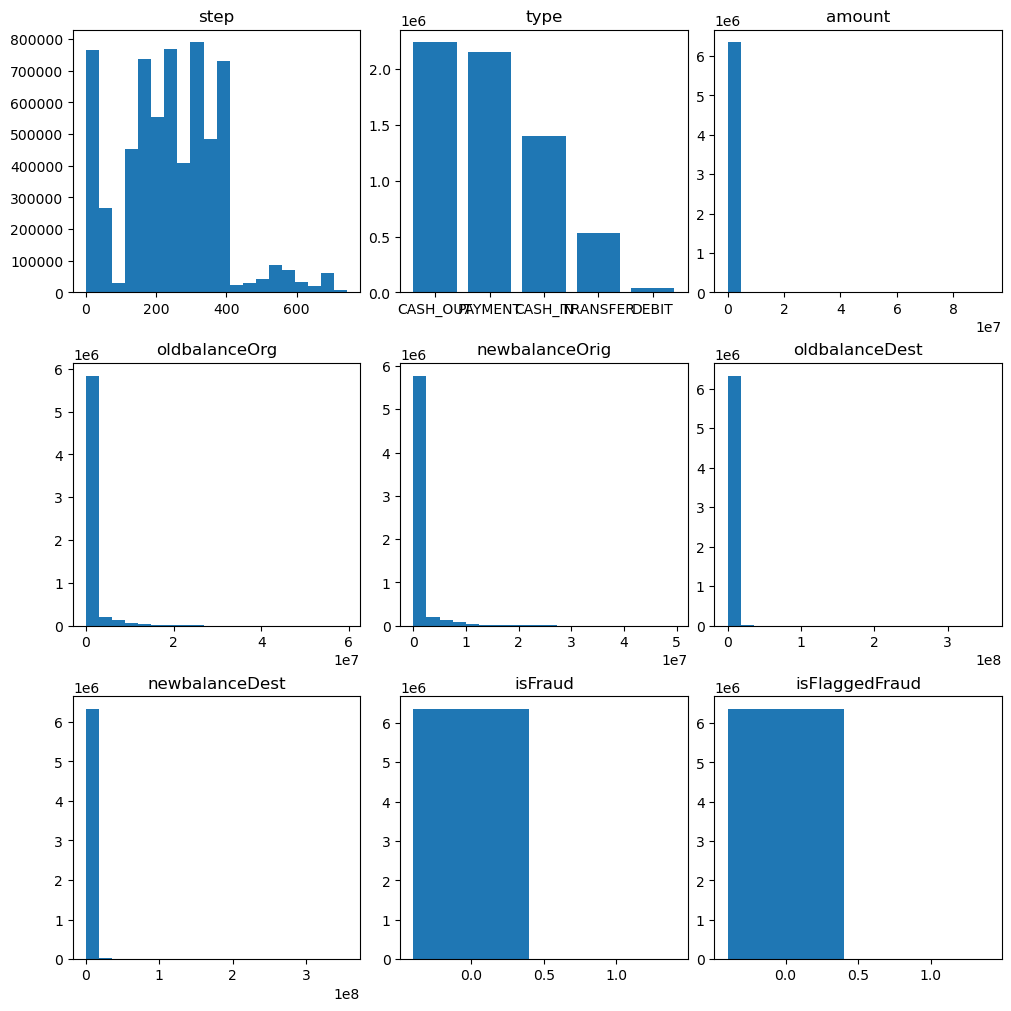

In [5]:
numerical_features = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
categorical_features = ['type', 'nameOrig', 'nameDest', 'isFraud', 'isFlaggedFraud']

fig, axes = plt.subplots(3, 3, figsize=(10, 10), layout='constrained')
cols_to_plot = [x for x in fraud.columns if x != 'nameOrig' and x != 'nameDest']

for col, ax in zip(cols_to_plot, axes.ravel()):
    if col in numerical_features:
        ax.hist(fraud[col], bins=20)
        ax.set_title(col)
    else:
        ax.bar(fraud[col].value_counts().index, fraud[col].value_counts().values)
        ax.set_title(col)

plt.show()

In [6]:
f'Percentage of fraudulent transactions: {fraud[fraud["isFraud"] == 1].shape[0] / fraud.shape[0]:.2%}'

'Percentage of fraudulent transactions: 0.13%'

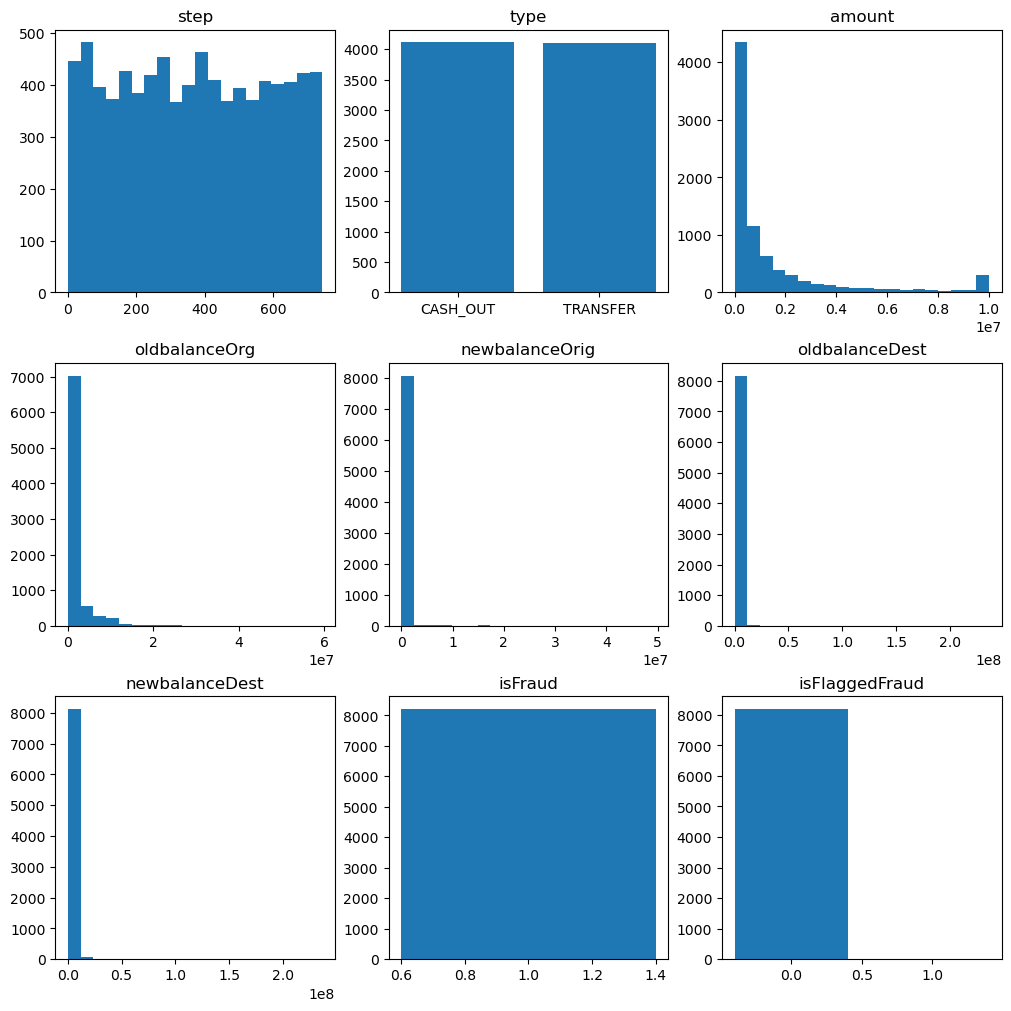

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10), layout='constrained')
fraud_filterd = fraud[fraud['isFraud'] == 1]

for col, ax in zip(cols_to_plot, axes.ravel()):
    if col in numerical_features:
        ax.hist(fraud_filterd[col], bins=20)
        ax.set_title(col)
    else:
        ax.bar(fraud_filterd[col].value_counts().index, fraud_filterd[col].value_counts().values)
        ax.set_title(col)

plt.show()

# Preprocessing

In [8]:
%run scripts/preprocess.py


-- Config -- 

RANDOM_SEED: 42
TRAIN_SIZE: 0.8
SHUFFLE: True
STRATIFY: True
FEATURES_TO_REMOVE: ['nameOrig', 'nameDest', 'isFlaggedFraud']
FEATURES_TO_SCALE: ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
FEATURES_TO_ENCODE: ['type']
SCALER: <class 'sklearn.preprocessing._data.StandardScaler'>
Initial shape: (6362620, 11)

-- Train, Valid, Test Split --

Features
Train: (5090096, 9) - Valid: (636262, 9) - Test (636262, 9)

Labels
Train: (5090096,) - Valid: (636262,) - Test (636262,)

Time Elapsed: 0.23 min


-- Scaling / Encoding --

Features to encode: ['type']
Features to scale: ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

Train: (5090096, 10) - Valid: (636262, 10) - Test (636262, 10)

Time Elapsed: 0.25 min

Preprocessing Complete. Time Elapsed: 0.26 min


# Baseline Training

In [1]:
%run scripts/train.py


-- Config -- 

RANDOM_SEED: 42
TRAIN_SIZE: 0.8
SHUFFLE: True
STRATIFY: True
FEATURES_TO_REMOVE: ['nameOrig', 'nameDest', 'isFlaggedFraud']
FEATURES_TO_SCALE: ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
FEATURES_TO_ENCODE: ['type']
SCALER: <class 'sklearn.preprocessing._data.StandardScaler'>

-- Fitting RandomForestClassifier --

Performance on Training Subset
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1: 1.00

Performance on Validation Subset
Accuracy: 1.00
Precision: 0.94
Recall: 0.90
F1: 0.92

Time Elapsed: 1.48 min


-- Fitting SVC --



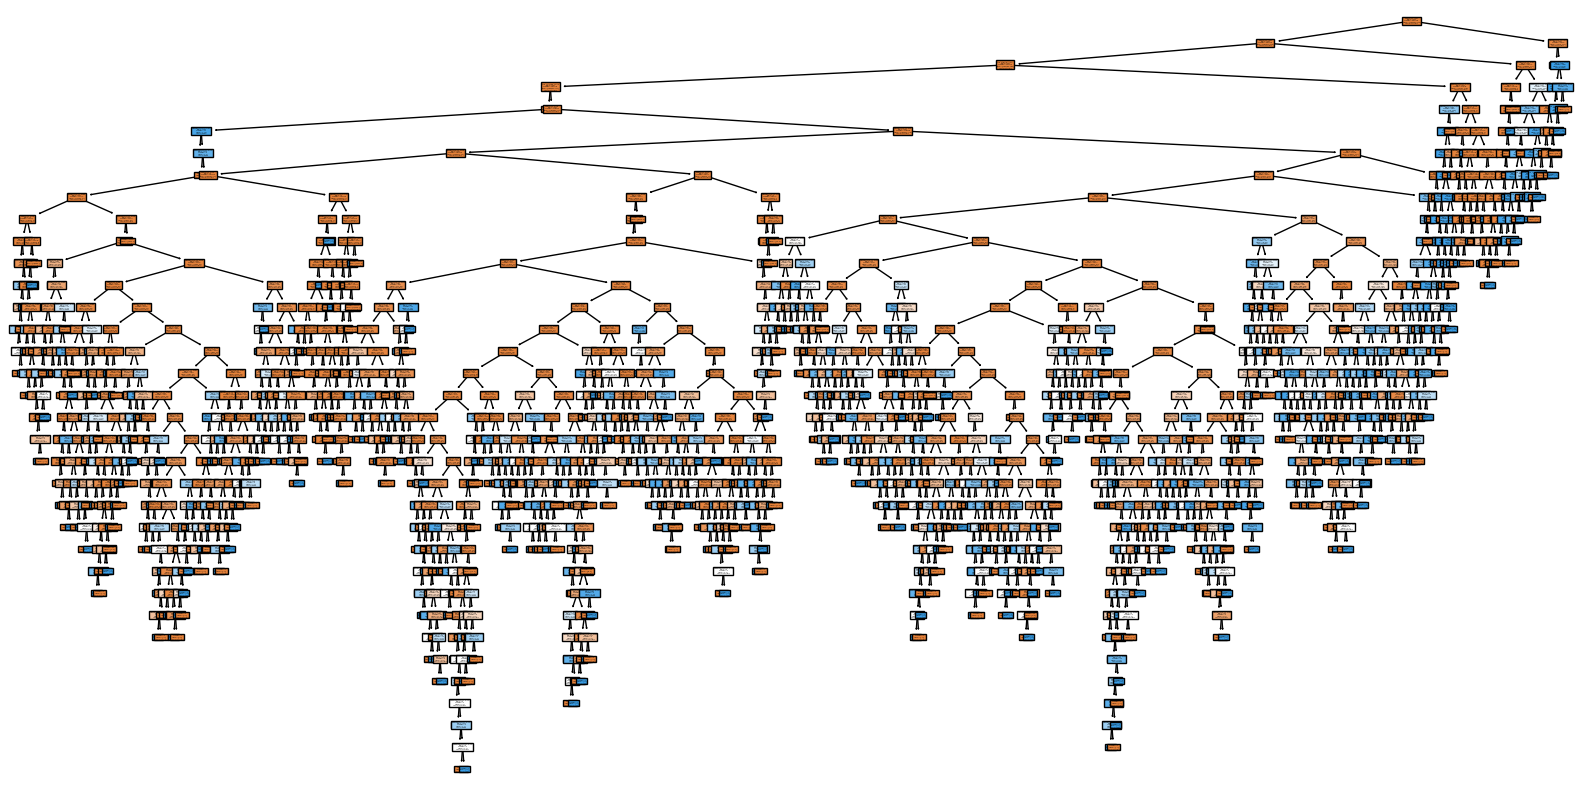

In [10]:
### FEATURE IMPORTANCE ###

## Tuning

We again require the full dataset for hyperparameter tuning, so we re-run preprocessing.

In [14]:
%run scripts/preprocess.py


-- Config -- 

RANDOM_SEED: 42
TRAIN_SIZE: 0.8
SHUFFLE: True
STRATIFY: True
FEATURES_TO_REMOVE: ['nameOrig', 'nameDest', 'isFlaggedFraud']
FEATURES_TO_SCALE: ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
FEATURES_TO_ENCODE: ['type']
SCALER: <class 'sklearn.preprocessing._data.StandardScaler'>
Initial shape: (6362620, 11)

-- Train, Valid, Test Split --

Features
Train: (5090096, 9) - Valid: (636262, 9) - Test (636262, 9)

Labels
Train: (5090096,) - Valid: (636262,) - Test (636262,)

Time Elapsed: 0.23 min


-- Scaling / Encoding --

Features to encode: ['type']
Features to scale: ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

Train: (5090096, 10) - Valid: (636262, 10) - Test (636262, 10)

Time Elapsed: 0.25 min

Preprocessing Complete. Time Elapsed: 0.26 min


In [14]:
%run scripts/tuning.py 


-- Config -- 

RANDOM_SEED: 42
TRAIN_SIZE: 0.8
SHUFFLE: True
STRATIFY: True
FEATURES_TO_REMOVE: ['nameOrig', 'nameDest', 'isFlaggedFraud']
FEATURES_TO_SCALE: ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
FEATURES_TO_ENCODE: ['type']
SCALER: <class 'sklearn.preprocessing._data.StandardScaler'>
Initial shape: (6362620, 11)

-- Train, Valid, Test Split --

Features
Train: (5090096, 9) - Valid: (636262, 9) - Test (636262, 9)

Labels
Train: (5090096,) - Valid: (636262,) - Test (636262,)

Time Elapsed: 0.24 min


-- Scaling / Encoding --

Features to encode: ['type']
Features to scale: ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

Train: (5090096, 10) - Valid: (636262, 10) - Test (636262, 10)

Time Elapsed: 0.26 min

Preprocessing Complete. Time Elapsed: 0.27 min

-- Config -- 

RANDOM_SEED: 42
TRAIN_SIZE: 0.8
SHUFFLE: True
STRATIFY: True
FEATURES_TO_REMOVE: ['nameOrig', 'nameDest', 'isFlaggedFraud']
FEATURES_TO_SCALE:

In [15]:
svm_results = pd.read_excel('logs/tuning_results_03.30_11.11.xlsx', engine='openpyxl', index_col=0, sheet_name='xgb')

display(svm_results.sort_values(by='valid_f1', ascending=False).head(10))

,model,train_accuracy,train_precision,train_recall,train_f1,valid_accuracy,valid_precision,valid_recall,valid_f1,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,random_state,splitter
386,dt,0.999959,0.993331,0.974886,0.984022,0.999783,0.927500,0.902676,0.914920,entropy,30.0,1,2,5,42,best
384,dt,0.999962,0.995187,0.975647,0.985320,0.999782,0.925280,0.903893,0.914462,entropy,30.0,1,2,2,42,best
224,dt,0.999960,0.993640,0.975038,0.984251,0.999782,0.927409,0.901460,0.914250,entropy,NaN,1,2,5,42,best
222,dt,0.999963,0.995345,0.976256,0.985708,0.999777,0.927136,0.897810,0.912237,entropy,NaN,1,2,2,42,best
378,dt,0.999999,0.999695,0.999239,0.999467,0.999772,0.911300,0.912409,0.911854,entropy,30.0,1,1,2,42,best
218,dt,0.999972,0.993096,0.985236,0.989150,0.999772,0.913309,0.909976,0.911639,entropy,NaN,1,1,5,42,best
380,dt,0.999972,0.993397,0.984627,0.988993,0.999772,0.914321,0.908759,0.911531,entropy,30.0,1,1,5,42,best
216,dt,1.000000,1.000000,1.000000,1.000000,0.999763,0.906667,0.909976,0.908318,entropy,NaN,1,1,2,42,best
0,dt,1.000000,1.000000,1.000000,1.000000,0.999763,0.910649,0.905109,0.907871,gini,NaN,1,1,2,42,best
220,dt,0.999938,0.974211,0.977473,0.975840,0.999761,0.908537,0.906326,0.907430,entropy,NaN,1,1,10,42,best


,model,train_accuracy,train_precision,train_recall,train_f1,valid_accuracy,valid_precision,valid_recall,valid_f1,criterion,max_depth,max_features,n_estimators,n_jobs,random_state
37,rf,1.0,1.000000,1.0,1.000000,0.999794,0.941252,0.896594,0.918380,entropy,NaN,1,100,-1,42
63,rf,1.0,0.999848,1.0,0.999924,0.999791,0.941101,0.894161,0.917031,entropy,30.0,1,50,-1,42
1,rf,1.0,1.000000,1.0,1.000000,0.999791,0.944516,0.890511,0.916719,gini,NaN,1,100,-1,42
65,rf,1.0,1.000000,1.0,1.000000,0.999789,0.937659,0.896594,0.916667,entropy,30.0,1,200,-1,42
64,rf,1.0,1.000000,1.0,1.000000,0.999789,0.937659,0.896594,0.916667,entropy,30.0,1,100,-1,42
38,rf,1.0,1.000000,1.0,1.000000,0.999789,0.937659,0.896594,0.916667,entropy,NaN,1,200,-1,42
36,rf,1.0,0.999848,1.0,0.999924,0.999789,0.942159,0.891727,0.916250,entropy,NaN,1,50,-1,42
28,rf,1.0,1.000000,1.0,1.000000,0.999788,0.944373,0.888078,0.915361,gini,30.0,1,100,-1,42
29,rf,1.0,1.000000,1.0,1.000000,0.999786,0.945455,0.885645,0.914573,gini,30.0,1,200,-1,42
0,rf,1.0,0.999696,1.0,0.999848,0.999786,0.945455,0.885645,0.914573,gini,NaN,1,50,-1,42


,model,train_accuracy,train_precision,train_recall,train_f1,valid_accuracy,valid_precision,valid_recall,valid_f1,gamma,learning_rate,max_depth,n_estimators,n_jobs,random_state,subsample
214,xgb,0.999732,0.972767,0.815525,0.887233,0.999668,0.952593,0.782238,0.859051,1.0,0.1,10,200,-1,42,0.8
69,xgb,0.999739,0.973100,0.820396,0.890247,0.999665,0.953800,0.778589,0.857334,0.1,0.2,6,200,-1,42,0.6
150,xgb,0.999742,0.971639,0.823896,0.891689,0.999662,0.943066,0.785888,0.857332,0.5,0.2,6,200,-1,42,0.6
70,xgb,0.999750,0.974901,0.827702,0.895291,0.999662,0.945668,0.783455,0.856953,0.1,0.2,6,200,-1,42,0.8
73,xgb,0.999709,0.975519,0.794521,0.875765,0.999665,0.957895,0.774939,0.856759,0.1,0.2,10,50,-1,42,0.8
232,xgb,0.999725,0.974138,0.808371,0.883547,0.999664,0.955090,0.776156,0.856376,1.0,0.2,6,200,-1,42,0.8
213,xgb,0.999748,0.970279,0.829833,0.894577,0.999659,0.945508,0.781022,0.855430,1.0,0.1,10,200,-1,42,0.6
151,xgb,0.999744,0.974087,0.823896,0.892719,0.999659,0.946824,0.779805,0.855237,0.5,0.2,6,200,-1,42,0.8
237,xgb,0.999754,0.966013,0.839269,0.898192,0.999654,0.932471,0.789538,0.855072,1.0,0.2,10,100,-1,42,0.6
235,xgb,0.999709,0.972336,0.797108,0.876046,0.999661,0.957704,0.771290,0.854447,1.0,0.2,10,50,-1,42,0.8


## Final Run with Full Data and Optimal Hyperparameters

In [16]:
hyperparams = {
    'rf': {
        'n_estimators': 100,
        'criterion': 'entropy',
        'max_depth': None,
        'max_features': 1.0,
        'random_state': config['RANDOM_SEED'],
        'n_jobs': -1
    },
    'svm': {
        'C': 0.1,
        'kernel': 'sigmoid',  
        'gamma': 1,  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.
        'degree': 3,  # Only signiifiicant for 'poly'.
        'coef0': 0.5,  # Only significant in 'poly' and 'sigmoid'.
        'random_state': config['RANDOM_SEED'],
    }
}

X_train = np.load('data/processed/X_train.npy')
y_train = np.load('data/processed/y_train.npy')

X_valid = np.load('data/processed/X_valid.npy')
y_valid = np.load('data/processed/y_valid.npy')

rf = RandomForestClassifier(**hyperparams['rf'])
svm = SVC(**hyperparams['xgb'])

models = [rf, svm]

for model in models:
    print(f'\n-- Fitting {model.__class__.__name__} --\n')
    # Train model
    model.fit(X_train, y_train)
    # Get evaluation metrics
    print('Performance on Training Subset')
    train_accuracy, train_precision, train_recall, train_f1 = evaluate(model, X_train, y_train)
    print('Performance on Validation Subset')
    valid_accuracy, valid_precision, valid_recall, valid_f1 = evaluate(model, X_valid, y_valid)
    # Log results
    result = pd.DataFrame({
        'model': model.__class__.__name__,
        'train_accuracy': train_accuracy,
        'train_precision': train_precision,
        'train_recall': train_recall,
        'train_f1': train_f1,
        'valid_accuracy': valid_accuracy,
        'valid_precision': valid_precision,
        'valid_recall': valid_recall,
        'valid_f1': valid_f1
    }, index=[0])


-- Fitting DecisionTreeClassifier --

Performance on Training Subset
Accuracy: 1.00
Precision: 0.99
Recall: 0.98
F1: 0.98

Performance on Validation Subset
Accuracy: 1.00
Precision: 0.93
Recall: 0.90
F1: 0.91


-- Fitting RandomForestClassifier --

Performance on Training Subset
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1: 1.00

Performance on Validation Subset
Accuracy: 1.00
Precision: 0.94
Recall: 0.90
F1: 0.92


-- Fitting XGBClassifier --

Performance on Training Subset
Accuracy: 1.00
Precision: 0.97
Recall: 0.89
F1: 0.93

Performance on Validation Subset
Accuracy: 1.00
Precision: 0.92
Recall: 0.80
F1: 0.85



In [17]:
X_train = np.concatenate([X_train, X_valid])
y_train = np.concatenate([y_train, y_valid])

X_test = np.load('data/processed/X_test.npy')
y_test = np.load('data/processed/y_test.npy')

print(
    f'Final training set size: {X_train.shape} - {y_train.shape}'
    f'\nFinal test set size: {X_test.shape} - {y_test.shape}'
)

Final training set size: (5726358, 10) - (5726358,)
Final test set size: (636262, 10) - (636262,)


In [18]:
rf = RandomForestClassifier(**hyperparams['rf'])
svm = SVC(**hyperparams['xgb'])

models = [rf, svm]

for model in models:
    print(f'\n-- Fitting {model.__class__.__name__} --\n')
    # Train model
    model.fit(X_train, y_train)
    # Get evaluation metrics
    print('Performance on Training + Validation Subset')
    train_accuracy, train_precision, train_recall, train_f1 = evaluate(model, X_train, y_train)
    print('Performance on Test Subset')
    test_accuracy, test_precision, test_recall, test_f1 = evaluate(model, X_test, y_test)
    # Log results
    result = pd.DataFrame({
        'model': model.__class__.__name__,
        'train_accuracy': train_accuracy,
        'train_precision': train_precision,
        'train_recall': train_recall,
        'train_f1': train_f1,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1
    }, index=[0])


-- Fitting DecisionTreeClassifier --

Performance on Training + Validation Subset
Accuracy: 1.00
Precision: 0.99
Recall: 0.97
F1: 0.98

Performance on Test Subset
Accuracy: 1.00
Precision: 0.92
Recall: 0.89
F1: 0.91


-- Fitting RandomForestClassifier --

Performance on Training + Validation Subset
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1: 1.00

Performance on Test Subset
Accuracy: 1.00
Precision: 0.93
Recall: 0.91
F1: 0.92


-- Fitting XGBClassifier --

Performance on Training + Validation Subset
Accuracy: 1.00
Precision: 0.97
Recall: 0.89
F1: 0.93

Performance on Test Subset
Accuracy: 1.00
Precision: 0.92
Recall: 0.81
F1: 0.86

